In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

file = open("/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/combine.pkl","rb")
combinations = pickle.load(file)

In [2]:
combinations_no_response = [(c[0], c[1], c[2]) for c in combinations]
combinations_no_response = list(set(combinations_no_response))

responses = list(set([u[3] for u in combinations.keys()]))
combinations_no_response


[('amap03', 'C5M-C5LL', 'S'),
 ('amap03', 'C6L-C6LL', 'B'),
 ('amap08', 'C5LM2-C5LL', 'S'),
 ('amap08', 'C5M-C5L', 'B'),
 ('amap07', '-C6M', 'B'),
 ('amap06', 'C6M-C6LL', 'S'),
 ('amap06', '-C6LL', 'S'),
 ('amap01', '-C6LM', 'B'),
 ('amap02', '-C6LL', 'B'),
 ('amap04', '-C5L', 'S'),
 ('amap07', '-C5M', 'S'),
 ('amap03', 'C6LM2-C6LL', 'S'),
 ('amap01', 'C6LM-C6R', 'B'),
 ('amap06', 'C6M-C6LM2', 'S'),
 ('amap02', 'C5LM2-C6L', 'S-B'),
 ('amap03', '-C5L', 'B'),
 ('amap02', '-C5LM1', 'S'),
 ('amap05', 'C6L-C6LL', 'S'),
 ('amap07', '-C6RR', 'B'),
 ('amap04', 'C5M-C5LM2', 'S'),
 ('amap06', 'C6R-C6RR', 'B'),
 ('amap04', '-C6RR', 'B'),
 ('amap02', 'C6M-C6RR', 'B'),
 ('amap02', '-C6M', 'B'),
 ('amap03', '-C6LM1', 'S'),
 ('amap07', 'C5M-C5L', 'S'),
 ('amap06', 'C6M-C6R', 'B'),
 ('amap02', '-C7M', 'B'),
 ('amap01', 'C7LM-C7M', 'B'),
 ('amap04', '-C6M', 'B'),
 ('amap04', 'C5LM2-C5L', 'S'),
 ('amap02', '-C7LM', 'B'),
 ('amap08', '-C6L', 'S'),
 ('amap04', '-C6LM2', 'S'),
 ('amap05', 'C6M-C6LM1', 'S')

In [3]:
arr = None

for muscle in responses:
    arr_muscle = None

    for c in combinations_no_response:
        a = combinations[(*c, muscle)]["a"]
        a = a[:, 0, 0, 0, 0]

        if arr_muscle is None:
            arr_muscle = a[:, None]
        else:
            # concatenate now
            arr_muscle = np.concatenate([arr_muscle, a[:, None]], axis=-1)

    if arr is None:
        arr = arr_muscle[:,:, None]

    else:
        arr = np.concatenate([arr, arr_muscle[:,:, None]], axis = -1)

In [4]:
ind = []

for c in combinations_no_response:
    if c == combinations_no_response[0]: 
        ind.append(True)
    else:
        ind.append(False)

ind = np.array(ind)


In [5]:
arr.shape

(4000, 403, 6)

In [6]:
ind = [
    True for u in combinations_no_response if u == combinations_no_response[0]
]


mask = np.array([bool(re.search(r'.+-.+', s[1])) for s in combinations_no_response])
filter_noGround = arr[:,mask,:]



In [7]:
filter_noGround.shape

(4000, 252, 6)

In [8]:
# def des_pos(pos):
positions = list(set([c[1] for c in combinations_no_response]))
mask = np.array([bool("-C6R" in s[1]) for s in combinations_no_response])
pos_filt = arr[:,mask,:]
ttest_all = []
pval_all = []
m2 = []
for p in positions:
    m2 = np.array([bool(p in s[1]) for s in combinations_no_response])
    comp_filt = arr[:,m2,:]
    ttest, pval = stats.ttest_ind(pos_filt, comp_filt)
    ttest_all.append(ttest)
    pval_all.append(pval)


ValueError: Array shapes are incompatible for broadcasting.

In [ ]:
positions = list(set([c[1] for c in combinations_no_response]))
mask = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LL") for s in combinations_no_response])
pos_filt = arr[:,mask,:]
pos_filt = pos_filt.mean(axis = 0).reshape(-1,)
ttest_all = []
pval_all = []
m2 = []

b = np.array([bool(s[2] == "B" ) for s in combinations_no_response])
s = np.array([bool(s[2] == "S" ) for s in combinations_no_response])
big = arr[:,b,:] 
small = arr[:,s,:]

for p in positions:
    m2 = np.array([bool(p in s[1]) for s in combinations_no_response])
    comp_filt = arr[:,m2,:]
    comp_filt = comp_filt.mean(axis = 0).reshape(-1,)
    ttest, pval = stats.ttest_ind(pos_filt, comp_filt)
    ttest_all.append(ttest)
    pval_all.append(pval)

In [ ]:
set([k[1] for k in combinations.keys()])

{'-C5L',
 '-C5LL',
 '-C5LM',
 '-C5LM1',
 '-C5LM2',
 '-C5M',
 '-C6L',
 '-C6LL',
 '-C6LM',
 '-C6LM1',
 '-C6LM2',
 '-C6M',
 '-C6R',
 '-C6RM',
 '-C6RR',
 '-C7LM',
 '-C7M',
 '-C7R',
 '-C7RM',
 '-C7RR',
 'C5L-C5LL',
 'C5LM1-C5L',
 'C5LM1-C5LL',
 'C5LM2-C5L',
 'C5LM2-C5LL',
 'C5LM2-C5LM1',
 'C5LM2-C5M',
 'C5LM2-C6L',
 'C5LM2-C6LL',
 'C5M-C5L',
 'C5M-C5LL',
 'C5M-C5LM',
 'C5M-C5LM1',
 'C5M-C5LM2',
 'C5M-C6L',
 'C5M-C6LL',
 'C6L-C6LL',
 'C6LL-C6L',
 'C6LM-C6L',
 'C6LM-C6LL',
 'C6LM-C6M',
 'C6LM-C6R',
 'C6LM-C6RM',
 'C6LM-C6RR',
 'C6LM1-C6L',
 'C6LM1-C6LL',
 'C6LM2-C6L',
 'C6LM2-C6LL',
 'C6LM2-C6LM1',
 'C6M-C6L',
 'C6M-C6LL',
 'C6M-C6LM',
 'C6M-C6LM1',
 'C6M-C6LM2',
 'C6M-C6R',
 'C6M-C6RM',
 'C6M-C6RR',
 'C6R-C6RR',
 'C6RM-C6R',
 'C6RM-C6RR',
 'C7LM-C7M',
 'C7LM-C7R',
 'C7LM-C7RM',
 'C7LM-C7RR',
 'C7M-C7R',
 'C7M-C7RM',
 'C7M-C7RR',
 'C7R-C7RR',
 'C7RM-C7R',
 'C7RM-C7RR'}

In [ ]:
dictBool = {}

dictBool[('LL', 'S')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LL" and s[2] == "S") for s in combinations_no_response])
dictBool[('L', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "L" and s[2] == "S") for s in combinations_no_response])
dictBool[('LM1', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LM1" and s[2] == "S") for s in combinations_no_response])
dictBool[('LM2', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LM2" and s[2] == "S") for s in combinations_no_response])
dictBool[('M', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "M" and s[2] == "S") for s in combinations_no_response])
dictBool[('LL', 'B')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LL" and s[2] == "B") for s in combinations_no_response])
dictBool[('L', 'B')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "L" and s[2] == "B") for s in combinations_no_response])
dictBool[('LM', 'B')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LM" and s[2] == "B") for s in combinations_no_response])
dictBool[('M', 'B')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "M" and s[2] == "B") for s in combinations_no_response])


In [ ]:
#BIG V SMALL

def bvs(pos, which):
    for k,v in dictBool.items():
        value = []
        if pos == "LM1" and k[0] == pos:
                S = arr[:,v,:].mean(axis = 0).reshape(-1,)
                for k1, v1 in dictBool.items():
                    if k1[1] == "B" and k1[0] == "LM":
                        B = arr[:,v1,:].mean(axis = 0).reshape(-1,)
                        tbvs, pbvs = stats.ttest_ind(B,S, alternative="less")
                        if pbvs < 0.05:
                            value.append(f"{k1} is more effective than {k} (p = {pbvs})")
                        else: value.append(f"No significant difference for {k1} vs {k} (p = {pbvs})")
                    else: pass
                return value
        
        elif which == "S":
            if k[0] == pos and k[1] == which:
                tar = arr[:,v,:]
                for k1,v1 in dictBool.items():
                    if k1[0] != pos and k1[1] == which:
                        a1 = arr[:,v,:].mean(axis = 0).reshape(-1,)
                        a2 = arr[:,v1,:] .mean(axis = 0).reshape(-1,)
                        tbvs, pbvs = stats.ttest_ind(a1,a2, alternative="less")
                        if pbvs < 0.05:
                            value.append(f"{k} is more effective than {k1} (p = {pbvs})")
                        else: value.append(f"No significant difference for {k} vs {k1} (p = {pbvs})")
                return value

        if which == "B":
            if k[0] == pos and k[1] == which:
                tar = arr[:,v,:]
                for k1,v1 in dictBool.items():
                    if k1[0] != pos and k1[1] == "B":
                        a1 = arr[:,v,:].mean(axis = 0).reshape(-1,)
                        a2 = arr[:,v1,:] .mean(axis = 0).reshape(-1,)
                        tbvs, pbvs = stats.ttest_ind(a1,a2, alternative="less")
                        if pbvs < 0.05:
                            value.append(f"{k} is more effective than {k1} (p = {pbvs})")
                        else: value.append(f"No significant difference for {k} vs {k1} (p = {pbvs})")            
                return value
        

        if which == "C" and k[0] == pos and k[1] == "B":
            B = arr[:,v,:].mean(axis = 0).reshape(-1,)
            for k1, v1 in dictBool.items():
                if k1[1] == "S":
                    S = arr[:,v1,:].mean(axis = 0).reshape(-1,)
                    tbvs, pbvs = stats.ttest_ind(B,S, alternative="less")
                    if pbvs < 0.05:
                        value.append(f"{k} is more effective than {k1} (p = {pbvs})")
                    else: value.append(f"No significant difference for {k} vs {k1} (p = {pbvs})")
                else: pass
            return value

    return value
        


In [ ]:
#this is one sided t test
a, q = bvs('LL', 'C')
q


[(('LL', 'B'),
  array([264.40417776, 467.06206121, 346.04692723, 300.46342753,
         359.87656757, 329.06335282, 213.39713513,  31.22251554,
         276.49040866,  36.0255197 , 335.50643072, 227.10614353,
           4.06515395,  35.36949324,  26.07359311,  39.01212246,
           4.89788716,  11.74714148,  60.32123002,  87.8865519 ,
          30.62194698,  21.47773727,  33.86850966,  50.63043115,
         374.92241303, 537.01194164, 520.43190336, 655.77448519,
         382.87681283, 435.70211516, 128.54175969, 121.13111031,
          56.54138437,  55.44290908,  61.60672379,  58.20256493,
         203.25927669,  52.02457113, 218.0570508 ,  46.7571204 ,
         317.95354503, 213.7579201 , 284.21351861, 120.78116726,
         172.87112921,  53.67934554, 245.11737067, 235.55995774,
          93.60436179, 148.15813628, 117.39034302, 124.0616805 ,
          98.20155048,  80.50772726,  97.30114101, 151.69172808,
         119.00392249, 130.15657873, 106.29204131,  99.12993903,
          

In [ ]:
p = [p[0] for p in dictBool.keys()]
mydict = {}

for val in p:
    small = bvs(val, "S")
    big = bvs(val,"B")
    mydict[val, "S"] = small
    mydict[val, "B"] = big
    combo= bvs(val,"C")
    mydict[val, "Big vs Small"] = combo


In [ ]:
ts

[(('M', 'S'),
  array([232.40604696, 434.24463775, 228.93739997, 374.26399181,
         390.9087966 , 230.37812821, 112.75861865,  61.24262269,
          64.04186662,  36.27853084,  36.53236929,  33.61182677])),
 (('LL', 'S'),
  array([148.65441508,  90.20294894,  62.68448663,  31.43852406,
          42.90675095,  41.95724643, 466.56135875, 131.80153307,
          93.05208353, 120.6370164 , 423.130309  ,  72.82293045,
         111.90733333, 135.73511935,  68.29220039, 121.6667733 ,
         110.32448998,  83.43611115, 307.78205122, 223.49499147,
         314.63733062, 179.27811939, 195.67815881, 254.94786991,
         206.43042619, 256.10039999, 134.7685076 , 125.10299838,
         289.10904337, 226.83586894, 269.63543059, 148.55315034,
          83.06890029, 199.43919041, 450.2880885 ,  96.45539494,
         139.82187732,  34.47098576,  33.71879084,  16.34099221,
          22.40569296,  15.7403621 , 465.41955711,  79.8165262 ,
          82.60534884, 107.59111308, 149.22756523,  50.505

In [ ]:
mydict.keys()

dict_keys([('LL', 'S'), ('LL', 'B'), ('LL', 'Big vs Small'), ('L', 'S'), ('L', 'B'), ('L', 'Big vs Small'), ('LM1', 'S'), ('LM1', 'B'), ('LM1', 'Big vs Small'), ('LM2', 'S'), ('LM2', 'B'), ('LM2', 'Big vs Small'), ('M', 'S'), ('M', 'B'), ('M', 'Big vs Small'), ('LM', 'S'), ('LM', 'B'), ('LM', 'Big vs Small')])

In [ ]:
for k,v in dictBool.items():
    if k[0] == "L" and k[1] == "S":
        tar = arr[:,v,:]
        for k1,v1 in dictBool.items():
            if k1[0] != "LL" and k1[1] == "S":
                a1 = arr[:,v,:].mean(axis = 0).reshape(-1,)
                a2 = arr[:,v1,:] .mean(axis = 0).reshape(-1,)
                tbvs, pbvs = stats.ttest_ind(a1,a2, alternative="less")
                print(f"The p value for {k} vs {k1} is {pbvs}")
    else: pass

In [ ]:
def filter_dict_by_strings(data, search_string):
    # Create a new dictionary to store the filtered results
    if not isinstance(data, dict):
        raise ValueError("Input data should be a dictionary.")
    
    filtered_dict = {}
    
    # Iterate over each key-value pair in the original dictionary
    for key, value_list in data.items():
        if not isinstance(value_list, list):
            print(f"Skipping key '{key}' because the value is not a list.")
            continue
        # Filter the value list for the search strings
        filtered_values = [item for item in value_list if search_string in item]
        
        # Add the filtered values to the new dictionary if not empty
        if filtered_values:
            filtered_dict[key] = filtered_values
    
    return filtered_dict

# a = filter_dict_by_strings(mydict, "effective")   

In [ ]:
b = bvs('LM1', 'S')


In [ ]:
a

{('M-LL',
  'Big vs Small'): ["('M-LL', 'B') is more effective than ('M-LL', 'S') (p = 0.0038092487500114634)"],
 ('M-L',
  'B'): ["('M-L', 'B') is more effective than ('M-LL', 'B') (p = 0.0002966804667118571)", "('M-L', 'B') is more effective than ('M-LM', 'B') (p = 0.0022280145873721817)"],
 ('M-L',
  'Big vs Small'): ["('M-L', 'B') is more effective than ('M-L', 'S') (p = 1.8820580235937052e-08)"]}

In [ ]:
a

{('LL',
  'Big vs Small'): ["('LL', 'B') is more effective than ('LL', 'S') (p = 1.502948464049102e-07)"],
 ('L',
  'S'): ["('L', 'S') is more effective than ('LL', 'S') (p = 0.00872552925447256)", "('L', 'S') is more effective than ('LM1', 'S') (p = 0.045480155030513086)"],
 ('L',
  'B'): ["('L', 'B') is more effective than ('LL', 'B') (p = 0.001596414263979888)", "('L', 'B') is more effective than ('LM', 'B') (p = 0.002980601929033017)"],
 ('L',
  'Big vs Small'): ["('L', 'B') is more effective than ('L', 'S') (p = 1.0939669470057542e-09)"],
 ('LM1',
  'S'): ["('LM', 'B') is more effective than ('LM1', 'S') (p = 0.0016625618682520197)"],
 ('LM1',
  'B'): ["('LM', 'B') is more effective than ('LM1', 'S') (p = 0.0016625618682520197)"],
 ('LM1',
  'Big vs Small'): ["('LM', 'B') is more effective than ('LM1', 'S') (p = 0.0016625618682520197)"],
 ('M',
  'B'): ["('M', 'B') is more effective than ('LL', 'B') (p = 0.03316568236739899)", "('M', 'B') is more effective than ('LM', 'B') (p = 0.

In [ ]:
dictBool.keys()

dict_keys([('LL', 'S'), ('L', 'S'), ('LM1', 'S'), ('LM2', 'S'), ('M', 'S'), ('LL', 'B'), ('L', 'B'), ('LM', 'B'), ('M', 'B')])

In [ ]:
left, right = ('LM1', 'S'), ('LM', 'B')
left, right = dictBool[left], dictBool[right]

left, right = arr[:, left, ...], arr[:, right, ...]

print(left.shape)
print(right.shape)


(4000, 26, 6)
(4000, 6, 6)


In [ ]:
left = left.mean(axis=0).reshape(-1,)
right = right.mean(axis=0).reshape(-1,)


In [ ]:
stats.ttest_ind(left, right, alternative="greater")

/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6951: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


TtestResult(statistic=nan, pvalue=nan, df=0.0)

In [ ]:
left, right = ('LM1', 'S'), ('LM', 'B')
left, right = dictBool[left], dictBool[right]

combinations_no_response


[('amap02', 'C6LM-C6R', 'B'),
 ('amap03', '-C6M', 'S'),
 ('amap02', '-C6LL', 'B'),
 ('amap06', '-C6LM1', 'S'),
 ('amap04', 'C6M-C6LL', 'S'),
 ('amap08', 'C6M-C6LM2', 'S'),
 ('amap02', 'C7LM-C7RR', 'B'),
 ('amap06', 'C6LM2-C6L', 'S'),
 ('amap05', 'C6M-C6L', 'S'),
 ('amap05', 'C6LM1-C6LL', 'S'),
 ('amap02', 'C5LM2-C6L', 'S-B'),
 ('amap07', '-C5LL', 'B'),
 ('amap01', '-C6RM', 'B'),
 ('amap02', 'C6M-C6RR', 'B'),
 ('amap01', '-C5L', 'B'),
 ('amap06', 'C6M-C6RM', 'B'),
 ('amap07', '-C6LM', 'B'),
 ('amap01', 'C5M-C6L', 'S-B'),
 ('amap05', 'C5LM2-C5LL', 'S'),
 ('amap06', '-C6M', 'B'),
 ('amap07', 'C6M-C6LM1', 'S'),
 ('amap02', 'C7M-C7R', 'B'),
 ('amap08', 'C5LM1-C5L', 'S'),
 ('amap05', 'C6RM-C6RR', 'B'),
 ('amap01', 'C5M-C5LL', 'B'),
 ('amap04', '-C6M', 'S'),
 ('amap01', 'C5M-C6LL', 'S-B'),
 ('amap03', '-C5L', 'S'),
 ('amap02', '-C5M', 'B'),
 ('amap04', '-C5LL', 'B'),
 ('amap07', 'C6LM1-C6LL', 'S'),
 ('amap07', 'C6M-C6L', 'S'),
 ('amap07', '-C5LL', 'S'),
 ('amap05', 'C5LM1-C5LL', 'S'),
 ('amap

In [ ]:
[u for u, b in zip(combinations_no_response, left) if b]

[('amap07', 'C6M-C6LM1', 'S'),
 ('amap04', 'C6M-C6LM1', 'S'),
 ('amap08', 'C5LM2-C5LM1', 'S'),
 ('amap03', 'C6LM2-C6LM1', 'S'),
 ('amap05', 'C5LM2-C5LM1', 'S'),
 ('amap07', 'C5M-C5LM1', 'S'),
 ('amap06', 'C6LM2-C6LM1', 'S'),
 ('amap04', 'C5M-C5LM1', 'S'),
 ('amap08', 'C6M-C6LM1', 'S'),
 ('amap02', 'C5LM2-C5LM1', 'S'),
 ('amap05', 'C6M-C6LM1', 'S'),
 ('amap08', 'C5M-C5LM1', 'S'),
 ('amap05', 'C5M-C5LM1', 'S'),
 ('amap03', 'C5LM2-C5LM1', 'S'),
 ('amap01', 'C5LM2-C5LM1', 'S'),
 ('amap06', 'C6M-C6LM1', 'S'),
 ('amap04', 'C6LM2-C6LM1', 'S'),
 ('amap06', 'C5LM2-C5LM1', 'S'),
 ('amap08', 'C6LM2-C6LM1', 'S'),
 ('amap05', 'C6LM2-C6LM1', 'S'),
 ('amap03', 'C6M-C6LM1', 'S'),
 ('amap07', 'C6LM2-C6LM1', 'S'),
 ('amap03', 'C5M-C5LM1', 'S'),
 ('amap07', 'C5LM2-C5LM1', 'S'),
 ('amap04', 'C5LM2-C5LM1', 'S'),
 ('amap06', 'C5M-C5LM1', 'S')]

# Lateral vs Medial

In [ ]:
dictBool = {}

dictBool[('M-LL', 'S')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LL" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-L', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "L" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-LM1', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LM1" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-LM2', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LM2" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-M', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "M" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-LL', 'B')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LL" and s[2] == "B") for s in combinations_no_response])
dictBool[('M-L', 'B')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "L" and s[2] == "B") for s in combinations_no_response])
dictBool[('M-LM', 'B')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LM" and s[2] == "B") for s in combinations_no_response])
dictBool[('M-M', 'B')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "M" and s[2] == "B") for s in combinations_no_response])

In [ ]:
p = [p[0] for p in dictBool.keys()]
lvm = {}

for val in p:
    small = bvs(val, "S")
    big = bvs(val,"B")
    lvm[val, "S"] = small
    lvm[val, "B"] = big
    combo = bvs(val,"C")
    lvm[val, "Big vs Small"] = combo


# lvm = filter_dict_by_strings(lvm, "effective")
lvm


{('M-LL',
  'S'): ["No significant difference for ('M-LL', 'S') vs ('M-L', 'S') (p = 0.8067021255541749)", "No significant difference for ('M-LL', 'S') vs ('M-LM1', 'S') (p = 0.32842767298269626)", "No significant difference for ('M-LL', 'S') vs ('M-LM2', 'S') (p = 0.33478527697588767)", "No significant difference for ('M-LL', 'S') vs ('M-M', 'S') (p = nan)"],
 ('M-LL',
  'B'): ["No significant difference for ('M-LL', 'B') vs ('M-L', 'B') (p = 0.9997033195332882)", "No significant difference for ('M-LL', 'B') vs ('M-LM', 'B') (p = 0.6373787933104573)", "No significant difference for ('M-LL', 'B') vs ('M-M', 'B') (p = nan)"],
 ('M-LL',
  'Big vs Small'): ["('M-LL', 'B') is more effective than ('M-LL', 'S') (p = 0.0038092487500114634)", "('M-LL', 'B') is more effective than ('M-L', 'S') (p = 0.021010603979913382)", "('M-LL', 'B') is more effective than ('M-LM1', 'S') (p = 0.0008296010230258683)", "('M-LL', 'B') is more effective than ('M-LM2', 'S') (p = 0.0007172801778900192)", "No signi

NameError: name 'n' is not defined

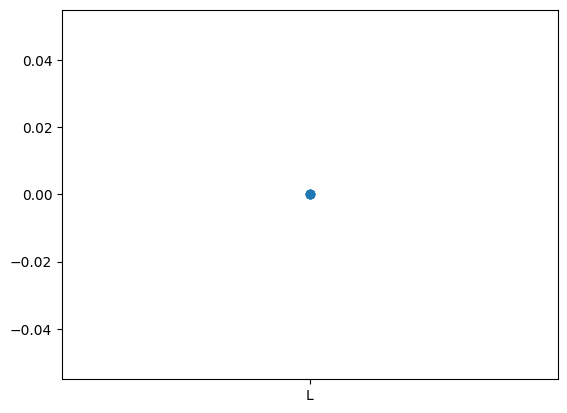

In [ ]:
target = {}
MLL= arr[:, dictBool[(('M-LL', 'S'))], ...].mean(axis = 0).reshape(-1,)
MLM1 = arr[:, dictBool[(('M-LM1', 'S'))], ...].mean(axis = 0).reshape(-1,)
MLM2 = arr[:, dictBool[(('M-LM2', 'S'))], ...].mean(axis = 0).reshape(-1,)
ML = arr[:, dictBool[(('M-L', 'S'))], ...].mean(axis = 0).reshape(-1,)
target.update({'MLL':MLL, 'ML':ML, 'MLM1':MLM1,'MLM2':MLM2})


val = [c[1] for c in target]
y=[0,0,0,0]


fig, ax = plt.subplots()

ax.scatter(val, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (val[i], y[i]))
plt.scatter(val,y)



In [ ]:
[u for u, b in zip(combinations_no_response, dictBool[('M-L', 'S')]) if b]

[('amap04', 'C6M-C6L', 'S'),
 ('amap04', 'C5M-C5L', 'S'),
 ('amap07', 'C6M-C6L', 'S'),
 ('amap06', 'C6M-C6L', 'S'),
 ('amap07', 'C5M-C5L', 'S'),
 ('amap05', 'C5M-C5L', 'S'),
 ('amap05', 'C6M-C6L', 'S'),
 ('amap03', 'C6M-C6L', 'S'),
 ('amap03', 'C5M-C5L', 'S'),
 ('amap06', 'C5M-C5L', 'S'),
 ('amap08', 'C6M-C6L', 'S'),
 ('amap08', 'C5M-C5L', 'S')]

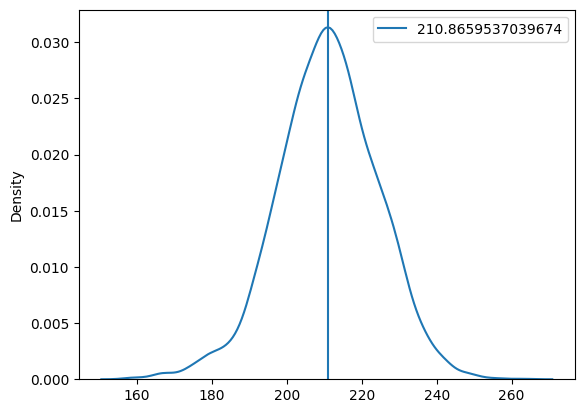

In [ ]:
ind = dictBool[('M-L', 'S')]
t = (arr[:, ind, ...])
samples = t.mean(axis=(-1, -2))
sns.kdeplot(samples)
plt.axvline(samples.mean(), label=f"{samples.mean()}")
plt.legend()

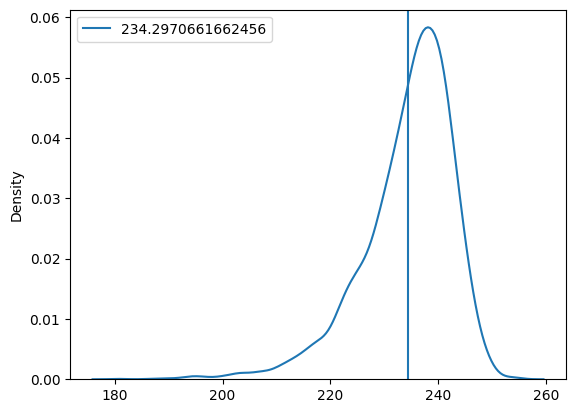

In [ ]:
ind = dictBool[('M-LL', 'S')]
t = (arr[:, ind, ...])
samples = t.mean(axis=(-1, -2))
sns.kdeplot(samples)
plt.axvline(samples.mean(), label=f"{samples.mean()}")
plt.legend()


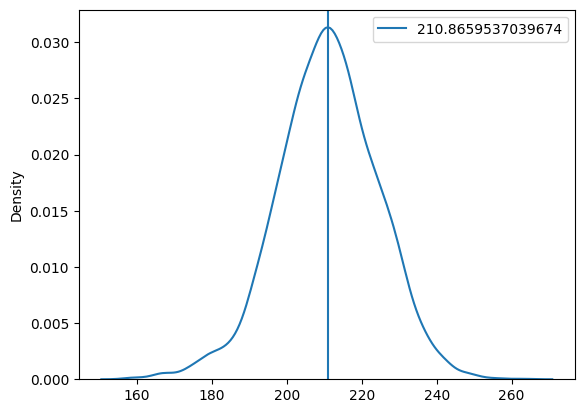

In [ ]:
ind = dictBool[('M-L', 'S')]
t = (arr[:, ind, ...])
samples = t.mean(axis=(-1, -2))
sns.kdeplot(samples)
plt.axvline(samples.mean(), label=f"{samples.mean()}")
plt.legend()

/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

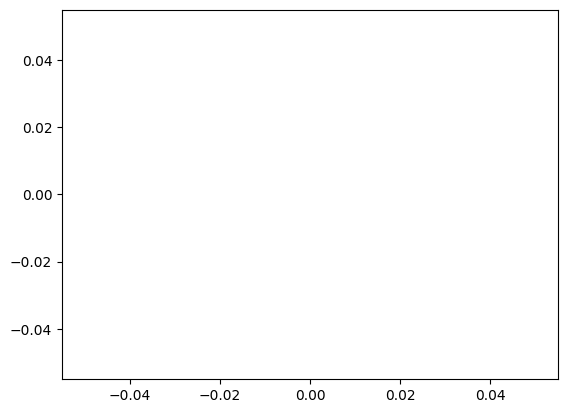

In [ ]:
for i, alignment in enumerate(["M-L", "M-LL", "M-LM1", "M-LM2"]):
    ind = dictBool[(alignment, 'S')]
    t = (arr[:, ind, ...])
    samples = t.mean(axis=(-1, -2))
    sns.scatterplot(samples)
    ax.axvline(samples.mean(), label=f"{samples.mean()}")
    ax.legend()
    ax.set_title((alignment, 'S'))
    



In [ ]:
points = []
sem = []
for i, alignment in enumerate(["M-L", "M-LL", "M-LM1", "M-LM2"]):
    ind = dictBool[(alignment, 'S')]
    t = (arr[:, ind, ...])
    samples = t.mean(axis=(-1, -2))
    points.append((alignment,samples.mean(),(np.std(samples)*2),'S'))

# sns.scatterplot(y=points)
points
    

[('M-L', 210.8659537039674, 26.74844948559197, 'S'),
 ('M-LL', 234.2970661662456, 17.053038134699534, 'S'),
 ('M-LM1', 247.14450411792308, 28.789959032641004, 'S'),
 ('M-LM2', 246.41229553952834, 39.499372764414126, 'S')]

In [ ]:
for i, alignment in enumerate(["M-L", "M-LL", "M-LM"]):
    ind = dictBool[(alignment, 'B')]
    t = (arr[:, ind, ...])
    samples = t.mean(axis=(-1, -2))
    points.append((alignment,samples.mean(),(np.std(samples)*2),  'B'))
    


In [ ]:
points

[('M-L', 210.8659537039674, 26.74844948559197, 'S'),
 ('M-LL', 234.2970661662456, 17.053038134699534, 'S'),
 ('M-LM1', 247.14450411792308, 28.789959032641004, 'S'),
 ('M-LM2', 246.41229553952834, 39.499372764414126, 'S'),
 ('M-L', 76.72815932837517, 9.669471282083688, 'B'),
 ('M-LL', 158.82228682796872, 26.538193234766595, 'B'),
 ('M-LM', 147.88095224665048, 29.11315824265616, 'B')]

In [ ]:
sem

[0.21149149872089867,
 0.13483295900178888,
 0.22763306662714278,
 0.31230900127430367,
 0.07645343982977826,
 0.2098290692919911,
 0.23018850018034123]

<ErrorbarContainer object of 3 artists>

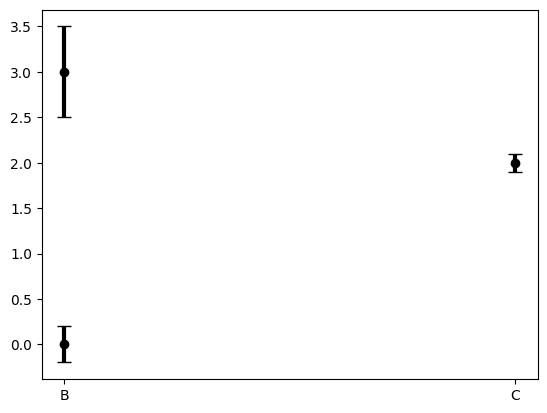

In [ ]:
plt.errorbar(['B', 'C', 'B'], [0, 2, 3], yerr=[.2, .1, .5], fmt='o', color='black', elinewidth=3, capsize=5)

<ErrorbarContainer object of 3 artists>

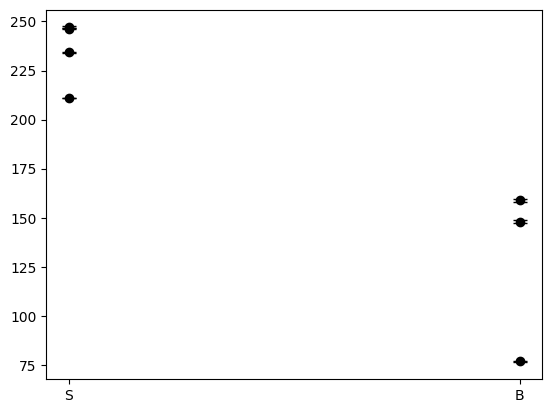

In [ ]:
plt.errorbar(ypoint, xpoint, yerr=[i / 10 for i in range(1, 8)], fmt='o', color='black', elinewidth=3, capsize=5)


In [ ]:
ypoint

['S', 'S', 'S', 'S', 'B', 'B', 'B']

In [ ]:
sem

[0.21149149872089867,
 0.13483295900178888,
 0.22763306662714278,
 0.31230900127430367,
 0.07645343982977826,
 0.2098290692919911,
 0.23018850018034123]

In [ ]:
xpoint

[210.8659537039674,
 234.2970661662456,
 247.14450411792308,
 246.41229553952834,
 76.72815932837517,
 158.82228682796872,
 147.88095224665048]

In [ ]:
col

['M-L', 'M-LL', 'M-LM1', 'M-LM2', 'M-L', 'M-LL', 'M-LM']

In [ ]:
ypoint_new = [0, .1, .2, .3, 1, 1.1,1.2]

ValueError: ['blue', 'red', 'green', 'darkgreen', 'blue', 'red', 'lime'] is not a valid value for color

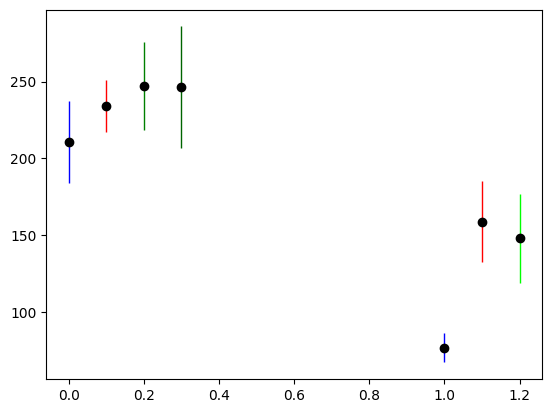

In [ ]:
xpoint = [x[1] for x in points]
ypoint = [x[3] for x in points]
col = [x[0] for x in points]
sem = [x[2] for x in points]

# sns.swarmplot(x = ypoint,y=xpoint, hue = col)
# plt.xlim((-1,2))
plt.errorbar(ypoint_new, xpoint, yerr=sem, fmt='o', color='black', elinewidth=1, capsize=4, ecolor = cols)
sns.despine()

plt.xticks([0.15, 1.1], ["S", "B"])
plt.ylabel("Threshold Value")
plt.title("Threshold Value by Size and Laterality")

In [ ]:
from matplotlib.lines import Line2D

Text(0.5, 1.0, 'Threshold Value by Size and Laterality')

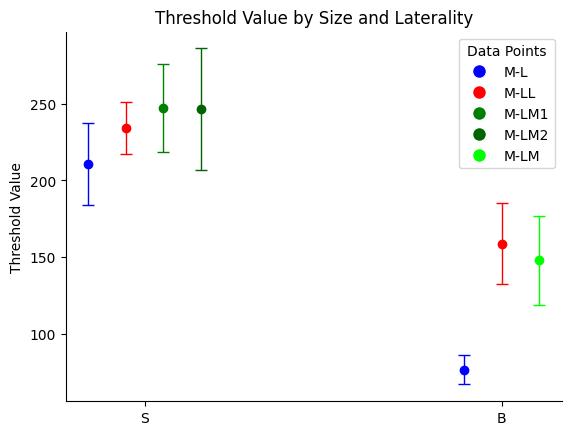

In [ ]:
labels = ['M-L', 'M-LL', 'M-LM1', 'M-LM2', 'M-L', 'M-LL', 'M-LM']

color_dict = {'M-L': 'blue', 'M-LL': 'red', 'M-LM1': 'green', 'M-LM2': 'darkgreen', 'M-LM': 'lime'}
colors = [color_dict[label] for label in labels]

for y, x, e, c in zip(ypoint_new, xpoint, sem, colors):
    plt.errorbar(y, x, yerr=e, fmt='o', color=c, elinewidth=1, capsize=4, ecolor=c)
    
unique_labels = list(color_dict.keys())
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10, label=label)
                  for label in unique_labels]
plt.legend(handles=legend_handles, title='Data Points')


sns.despine()
plt.xticks([0.15, 1.1], ["S", "B"])
plt.ylabel("Threshold Value")
plt.title("Threshold Value by Size and Laterality")
